# Working with cell-based coadds

A collection of useful snippets to get started with using cell-based coadds.

Last working stack: `d_2024_08_27`

## Load in relevant data

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.geom as afwGeom
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

Define the collection of interest

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'

## Example butler queries

Check which dataset types are registered in the collection.

In [3]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        print(datasetType)

DatasetType('packages', {}, Packages)
DatasetType('deepCoadd_directWarp', {band, instrument, skymap, day_obs, physical_filter, tract, patch, visit}, ExposureF)
DatasetType('makeDirectWarp_config', {}, Config)
DatasetType('deepCoaddCell', {band, skymap, tract, patch}, MultipleCellCoadd)
DatasetType('makeDirectWarp_metadata', {band, instrument, skymap, day_obs, physical_filter, tract, patch, visit}, TaskMetadata)
DatasetType('makeDirectWarp_log', {band, instrument, skymap, day_obs, physical_filter, tract, patch, visit}, ButlerLogRecords)
DatasetType('assembleCellCoadd_config', {}, Config)
DatasetType('assembleCellCoadd_metadata', {band, skymap, tract, patch}, TaskMetadata)
DatasetType('assembleCellCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)
DatasetType('deepCoadd_directWarp_maskedFraction', {band, instrument, skymap, day_obs, physical_filter, tract, patch, visit}, ImageF)


A useful object to look at is the configuration for a specific task. There is one object generated per quanta. We can summon one instance with the butler.

In [4]:
warp_config = butler.get('makeDirectWarp_config', 
                     collections = collection, 
                     instrument = 'HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch = 61,
                     band = 'i',)

The `warp_config` object behaves like a dictionary of the setting name and the value(s) of the setting at the time the correlated object was generated. These can be neatly accessed within a simple loop.

In [5]:
for key, value in warp_config.items():
    print(f"{key}: {value}")

saveLogOutput: True
numberOfNoiseRealizations: 0
seedOffset: 0
useMedianVariance: True
doRevertOldBackground: False
doApplyNewBackground: False
useVisitSummaryPsf: True
doSelectPreWarp: True
select: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fe3884fe590>
doPreWarpInterpolation: True
preWarpInterpolation: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fe38854ad90>
inputRecorder: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fe3969c6c90>
includeCalibVar: False
border: 256
warper: {'warpingKernelName': 'lanczos3', 'maskWarpingKernelName': 'bilinear', 'interpLength': 10, 'cacheSize': 0, 'growFullMask': 16}
doWarpMaskedFraction: True
maskedFractionWarper: {'warpingKernelName': 'bilinear', 'maskWarpingKernelName': 'bilinear', 'interpLength': 10, 'cacheSize': 1000000, 'growFullMask': 16}
coaddPsf: {'cacheSize': 10000, 'warpingKernelName': 'lanczos3'}
idGenerator: {'release_id': 0, 'n_releases': 1, 'packer': {'name': None, 

Below is a query to see how many objects of `deepCoadd_directWarp` are in the collection.

In [6]:
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    print(ref.dataId)

{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 51, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 48, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 62, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 57, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 73, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 56, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 60, visit: 1242, band: 'i', day_obs: 20140328, physical_filter: 'HSC-I'}

## Load in example warp

We will specifically look at patch 61 for this example.

In [7]:
patch = 61

Load in the warped image.

In [8]:
warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = 19684)

Take a look at the cell coadd structure

In [9]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

The cells within the produced coadd can be "stitched" together to produce a single coadd structure. Useful for displaying the image of an entire patch formed by combining all cells.

In [10]:
stitch_coadd = coadd.stitch()

Check the number of cells with inputs. For instance, the patch 37 contains 85 cells with inputs, while patch 61 has all 484 cells with inputs (484=22x22 cells in a patch, with this configuration).

In [11]:
cell_num = len(list(coadd.cells.keys()))
print(cell_num)

484


We can see a list of the available cells with their index information:

In [12]:
cell_list = list(coadd.cells.keys())
print(cell_list)

[Index2D(x=0, y=0), Index2D(x=1, y=0), Index2D(x=2, y=0), Index2D(x=3, y=0), Index2D(x=4, y=0), Index2D(x=5, y=0), Index2D(x=6, y=0), Index2D(x=7, y=0), Index2D(x=8, y=0), Index2D(x=9, y=0), Index2D(x=10, y=0), Index2D(x=11, y=0), Index2D(x=12, y=0), Index2D(x=13, y=0), Index2D(x=14, y=0), Index2D(x=15, y=0), Index2D(x=16, y=0), Index2D(x=17, y=0), Index2D(x=18, y=0), Index2D(x=19, y=0), Index2D(x=20, y=0), Index2D(x=21, y=0), Index2D(x=0, y=1), Index2D(x=1, y=1), Index2D(x=2, y=1), Index2D(x=3, y=1), Index2D(x=4, y=1), Index2D(x=5, y=1), Index2D(x=6, y=1), Index2D(x=7, y=1), Index2D(x=8, y=1), Index2D(x=9, y=1), Index2D(x=10, y=1), Index2D(x=11, y=1), Index2D(x=12, y=1), Index2D(x=13, y=1), Index2D(x=14, y=1), Index2D(x=15, y=1), Index2D(x=16, y=1), Index2D(x=17, y=1), Index2D(x=18, y=1), Index2D(x=19, y=1), Index2D(x=20, y=1), Index2D(x=21, y=1), Index2D(x=0, y=2), Index2D(x=1, y=2), Index2D(x=2, y=2), Index2D(x=3, y=2), Index2D(x=4, y=2), Index2D(x=5, y=2), Index2D(x=6, y=2), Index2

To pick out a single cell from the coadd, we can use any of the `Index2D` indices to pick one out.

In [13]:
example_cell = coadd.cells[Index2D(x=15,y=4)]

To see the number of input warps that went into a cell:

In [14]:
cell_inputs = example_cell.inputs
print(len(cell_inputs))

1


## Showing cell images

The backend used for displaying image data will be firefly here, though other options are available. 

Some other points:
- Define both `display1` and `display2` in the same notebook cell each time, to keep the displays updated and avoid loading image data from previous notebook cells.
- Firefly will load another tab within the notebook environment. Keep this tab open, since as far as I know the only way to get this tab back is to reload the notebook environment. Redefining the displays will update the current tab instead of creating a new tab.

In [15]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

The image data stored in a cell can be called in the following way: 

In [16]:
cell_imMask_out = coadd.cells[Index2D(x=0, y=0)].outer.asMaskedImage()
cell_imMask_in = coadd.cells[Index2D(x=0, y=0)].inner.asMaskedImage()

The inner cell is the boundary of just the single cell, whereas the outer cell contains overlapping image data with neighboring cells. To display the difference between those images, call the below notebook cell:

In [17]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(cell_imMask_out)
display2 = afwDisplay.Display(frame=2)
display2.mtv(cell_imMask_in)

We can also call on the `stitch_coadd` object to display all cells across an entire patch:

In [18]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitch_coadd.asExposure())

### Cells and input warps

Another way to visualize the cell information may be to plot both the cell image and a cutout of an input warp that aligns with the cell.

First pick a cell and see what input warps go into it.

In [19]:
cell_warps = list(coadd.cells[Index2D(x=15,y=4)].inputs)
cell_visits = [input.visit for input in cell_warps]
print(cell_visits)

[19684]


We can see that the example warp loaded in earlier is also an input for this cell, so we can use that one for viewing.

In [20]:
bbox = coadd.cells[Index2D(x=15,y=4)].outer.bbox
masked_warp = warp[bbox].getMaskedImage()

# display the cell and warp cutout side by side
display1 = afwDisplay.Display(frame=1)
display1.mtv(coadd.cells[Index2D(x=15,y=4)].outer.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(masked_warp.image)

### List of cells with a specific visit

Let's find all the cells that use a specific visit. First, query the butler for all possible visits for this patch.

In [21]:
visits = []

for ref in butler.registry.queryDatasets('deepCoadd_directWarp', 
                                         physical_filter='HSC-I', 
                                         collections=collection, 
                                         instrument='HSC', 
                                         tract=9813, 
                                         skymap = 'hsc_rings_cells_v1', 
                                         patch=61):
    visits.append(ref.dataId.get('visit'))

visits = np.unique(visits)
print(visits)

[ 1242  1248 19680 19684 19694 19696 30482 30490]


Now we have the list of all possible visits for these cells. Let's just pick the first one.

In [22]:
test_visit = 1242

In [23]:
cell_list_visits = [index for index in cell_list if (test_visit in [input.visit for input in list(coadd.cells[index].inputs)])]

In [24]:
print(len(cell_list_visits))
print(cell_list_visits)

396
[Index2D(x=0, y=0), Index2D(x=1, y=0), Index2D(x=2, y=0), Index2D(x=3, y=0), Index2D(x=4, y=0), Index2D(x=5, y=0), Index2D(x=6, y=0), Index2D(x=7, y=0), Index2D(x=8, y=0), Index2D(x=9, y=0), Index2D(x=10, y=0), Index2D(x=11, y=0), Index2D(x=12, y=0), Index2D(x=13, y=0), Index2D(x=14, y=0), Index2D(x=15, y=0), Index2D(x=16, y=0), Index2D(x=17, y=0), Index2D(x=18, y=0), Index2D(x=19, y=0), Index2D(x=20, y=0), Index2D(x=21, y=0), Index2D(x=0, y=1), Index2D(x=1, y=1), Index2D(x=2, y=1), Index2D(x=3, y=1), Index2D(x=4, y=1), Index2D(x=5, y=1), Index2D(x=6, y=1), Index2D(x=7, y=1), Index2D(x=8, y=1), Index2D(x=9, y=1), Index2D(x=10, y=1), Index2D(x=11, y=1), Index2D(x=12, y=1), Index2D(x=13, y=1), Index2D(x=14, y=1), Index2D(x=15, y=1), Index2D(x=16, y=1), Index2D(x=17, y=1), Index2D(x=18, y=1), Index2D(x=19, y=1), Index2D(x=20, y=1), Index2D(x=21, y=1), Index2D(x=0, y=2), Index2D(x=1, y=2), Index2D(x=2, y=2), Index2D(x=3, y=2), Index2D(x=4, y=2), Index2D(x=5, y=2), Index2D(x=6, y=2), In

### Distribution histograms of cell inputs

The number of inputs for cells will impact the final depth and noise of the coadds. It's useful to get an idea of how many visits each cell contains.

In [25]:
cell_list_filled = list(coadd.cells.keys())

The `cell_list_filled` variable only contains indices for cells that have input warps. This is useful in some areas, but requires some extra lines of code so our 2D histograms can handle empty cells.

The code cell below generates the fill list of cell indices for a patch of 22x22 cells. Another array, `cells_filled`, will keep track of which of these indices are filled. 

In [27]:
cell_list = []
cells_filled = [False] * coadd.grid.shape[0] * coadd.grid.shape[1]

index = 0
for i in range(coadd.grid.shape[0]):
    for j in range(coadd.grid.shape[1]):
        # Index2D axes are reverse of 2D list
        cell_list.append(Index2D(x=j,y=i))

        if Index2D(x=j,y=i) in cell_list_filled:
            cells_filled[index]=True

        index += 1

In [28]:
print(cell_list)

[Index2D(x=0, y=0), Index2D(x=1, y=0), Index2D(x=2, y=0), Index2D(x=3, y=0), Index2D(x=4, y=0), Index2D(x=5, y=0), Index2D(x=6, y=0), Index2D(x=7, y=0), Index2D(x=8, y=0), Index2D(x=9, y=0), Index2D(x=10, y=0), Index2D(x=11, y=0), Index2D(x=12, y=0), Index2D(x=13, y=0), Index2D(x=14, y=0), Index2D(x=15, y=0), Index2D(x=16, y=0), Index2D(x=17, y=0), Index2D(x=18, y=0), Index2D(x=19, y=0), Index2D(x=20, y=0), Index2D(x=21, y=0), Index2D(x=0, y=1), Index2D(x=1, y=1), Index2D(x=2, y=1), Index2D(x=3, y=1), Index2D(x=4, y=1), Index2D(x=5, y=1), Index2D(x=6, y=1), Index2D(x=7, y=1), Index2D(x=8, y=1), Index2D(x=9, y=1), Index2D(x=10, y=1), Index2D(x=11, y=1), Index2D(x=12, y=1), Index2D(x=13, y=1), Index2D(x=14, y=1), Index2D(x=15, y=1), Index2D(x=16, y=1), Index2D(x=17, y=1), Index2D(x=18, y=1), Index2D(x=19, y=1), Index2D(x=20, y=1), Index2D(x=21, y=1), Index2D(x=0, y=2), Index2D(x=1, y=2), Index2D(x=2, y=2), Index2D(x=3, y=2), Index2D(x=4, y=2), Index2D(x=5, y=2), Index2D(x=6, y=2), Index2

In [29]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

inputs_list = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

#### Plotting cell input 1D histogram

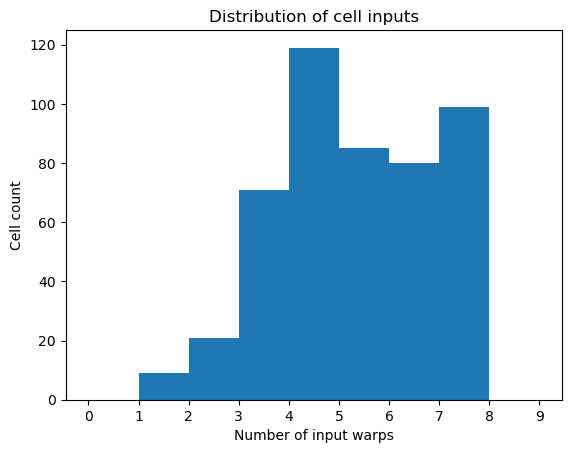

In [30]:
flat_inputs_list = inputs_list.flatten()

bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(flat_inputs_list, bins)
plt.show()

#### Generate 2D histogram of number of cell inputs across a patch

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [31]:
stitch_coadd.asExposure().getDimensions()

Extent2I(3400, 3400)

Get the grid structure of the stitched coadd:

In [32]:
print(stitch_coadd.grid)

UniformGrid(cell_size=Extent2I(150, 150), shape=(22, 22), min=Point2I(17850, 14850))


Plot the 2D grid of cell inputs:

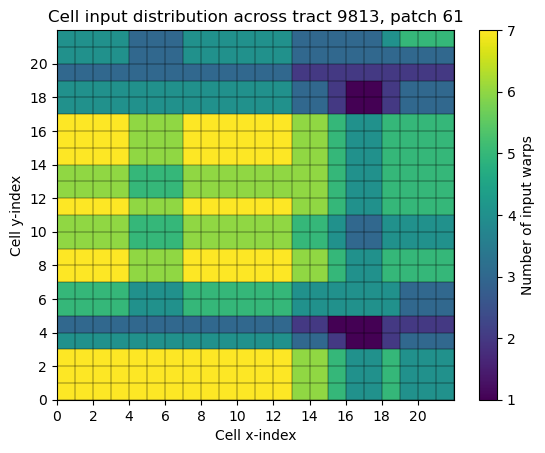

In [33]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
grid = [x for x in range(stitch_coadd.grid.shape[0]+1)]
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.hlines(y=grid, xmin=0, xmax=(grid[-1]), linestyle='-', lw=0.3, color='black')
plt.vlines(x=grid, ymin=0, ymax=(grid[-1]), linestyle='-', lw=0.3, color='black')

plt.title(f"Cell input distribution across tract 9813, patch {patch}")
plt.xlabel("Cell x-index")
plt.ylabel("Cell y-index")
plt.colorbar(label="Number of input warps")
plt.savefig("image_outputs/2d-input-distrib.png", bbox_inches='tight')
plt.show()

Brief check that index of cells are lining up as expected, since numpy indexes 2D arrays differently.

In [34]:
# for patch 61
print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

7
1
6


It might also be helpful to compare the stitched coadd image to the 2D input distribution histogram.

In [35]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(afwGeom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(afwGeom.Extent2I(50, 50))))
cutout = stitch_coadd.image[bbox]

extent = 0, cutout.getDimensions()[0], 0, cutout.getDimensions()[1]

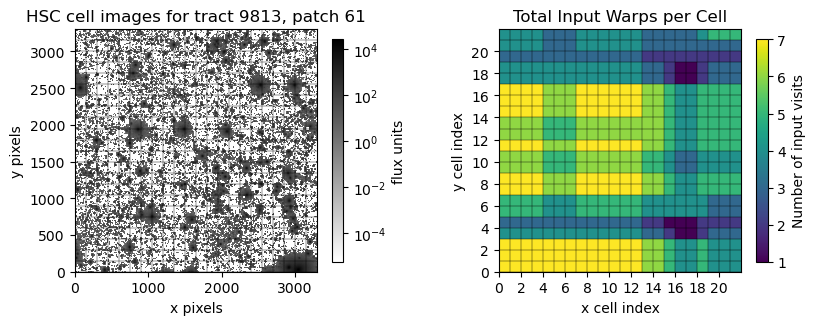

In [36]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig, axs = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.05)

stitched_image = axs[0].imshow(np.flip(cutout.array, axis=0),
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [axs[0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [axs[0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

axs[0].set_title(f"HSC cell images for tract 9813, patch {patch}")
axs[0].set_xlabel("x pixels")
axs[0].set_ylabel("y pixels")
axs[0].set_aspect('equal')

fig.colorbar(stitched_image, ax=axs[0], cmap='viridis', shrink=0.3, label="flux units")

cell_inputs = axs[1].pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [axs[1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1].set_title(f"Total Input Warps per Cell")
axs[1].set_xlabel("x cell index")
axs[1].set_ylabel("y cell index")
axs[1].set_aspect('equal')
axs[1].set_xticks(np.arange(0, 21, 2))
axs[1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=axs[1], cmap='viridis', shrink=0.3, label="Number of input visits")

# plt.savefig("image_outputs/2d-weighted-mask-fraction.png", bbox_inches='tight')
plt.show()

## Getting mask information from cells

### For a single cell

To see what masks are being used in a cell, load in the mask plane of an example cell.

In [37]:
cell_mask = coadd.cells[Index2D(x=0, y=0)].inner.mask

In [38]:
print(cell_mask.getMaskPlaneDict())

{'BAD': 0, 'CR': 3, 'CROSSTALK': 9, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NOT_DEBLENDED': 10, 'NO_DATA': 8, 'SAT': 1, 'STREAK': 11, 'SUSPECT': 7, 'UNMASKEDNAN': 12}


If you have the mask plane name, find what value is associated with it

In [39]:
print(cell_mask.getMaskPlane('CR'))

3


Get the number of pixels with a specific mask within a cell

In [40]:
mask_used = 'INTRP'
print("Mask used: ", mask_used)
mask_bit = cell_mask.getPlaneBitMask(mask_used)
print("Mask bit number: ", mask_bit)
num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.array, mask_bit))[0])
print("Number of masked pixels: ", num_bad_pixels)

Mask used:  INTRP
Mask bit number:  4
Number of masked pixels:  244


### For a whole patch

In [41]:
mask_used = 'CR'
print("Mask used: ", mask_used)
mask_bit = stitch_coadd.mask.getPlaneBitMask(mask_used)
print("Mask bit number: ", mask_bit)
num_bad_pixels = len(np.where(np.bitwise_and(stitch_coadd.mask.array, mask_bit))[0])
print("Number of masked pixels: ", num_bad_pixels)

Mask used:  CR
Mask bit number:  8
Number of masked pixels:  84877


### Plot distribution of masked pixels

Text(0, 0.5, 'Cell count')

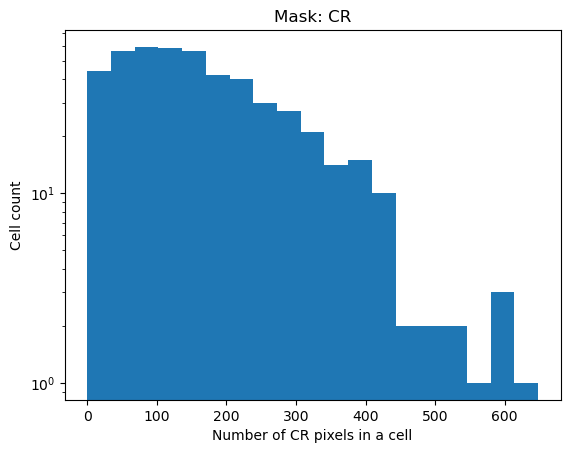

In [42]:
num_mask_pix = []
plot_mask = 'CR'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
some_cell = coadd.cells[cell_list_filled[0]]
mask_bit = some_cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list_filled:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    # optionally print cells that contain the defined masked pixels
    # if num_bad_pixels > 0:
    #     print(cell_index)
    num_mask_pix.append(num_bad_pixels)
    
num_mask_pix = np.array(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, (np.max(num_mask_pix)+1)/20)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

### Display the mask plane

See the warp and example cell mask planes.

In [43]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(coadd.cells[Index2D(x=11,y=11)].outer.mask)
display2 = afwDisplay.Display(frame=2)
display2.mtv(masked_warp.mask)